### Preprocessing 

In [3]:
import os
import xml.etree.ElementTree as ET
import cv2

def convert_to_yolo_format(bbox, img_size, class_id=0):
    """
    Convert bbox from Pascal VOC format [xmin, ymin, xmax, ymax] to YOLO format.
    """
    dw = 1. / img_size[0]
    dh = 1. / img_size[1]
    x = (bbox[0] + bbox[2]) / 2.0
    y = (bbox[1] + bbox[3]) / 2.0
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return f"{class_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}"

def parse_annotation(xml_file, image_folder):
    """
    Parse the XML file to get the bounding box coordinates and write them in YOLO format.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    image_path = os.path.join(image_folder, filename)
    img_size = cv2.imread(image_path).shape
    
    boxes = []
    for obj in root.iter('object'):
        class_id = 0  # TODO: Set the correct class ID if you have multiple classes
        xmlbox = obj.find('bndbox')
        bbox = (
            int(xmlbox.find('xmin').text),
            int(xmlbox.find('ymin').text),
            int(xmlbox.find('xmax').text),
            int(xmlbox.find('ymax').text),
        )
        boxes.append(convert_to_yolo_format(bbox, img_size, class_id))
    return filename, boxes

def save_yolo_annotations(annotations_path, image_folder, output_path):
    """
    Convert and save the annotations in YOLO format.
    """
    for xml_file in os.listdir(annotations_path):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotations_path, xml_file)
            filename, boxes = parse_annotation(xml_path, image_folder)
            
            # Remove image extension and add .txt extension
            base_filename = os.path.splitext(filename)[0]
            output_txt_path = os.path.join(output_path, f"{base_filename}.txt")
            
            # Write the YOLO formatted bounding boxes to a .txt file
            with open(output_txt_path, 'w') as file:
                for box in boxes:
                    file.write(box + "\n")

# Paths to your dataset
annotations_path = 'archive/annotations'
image_folder = 'archive/images'
output_path = 'archive/processed_images'

# Convert and save annotations in YOLO format
save_yolo_annotations(annotations_path, image_folder, output_path)


ParseError: not well-formed (invalid token): line 1, column 0 (<string>)

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import easyocr

In [29]:
def get_labels(image_directory):
    images, labels, cropped_plates, filenames = [], [], [], []
    reader = easyocr.Reader(['en'])

    #counter = 1

    for filename in os.listdir(image_directory):
        #print(counter)
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            #print(filename)
            img_path = os.path.join(image_directory, filename)
            img = cv2.imread(img_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            bfilter = cv2.bilateralFilter(gray, 11, 11, 17)
            edged = cv2.Canny(bfilter, 30, 200)

            keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            contours = imutils.grab_contours(keypoints)
            contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

            location = None
            for contour in contours:
            # cv2.approxPolyDP returns a resampled contour, so this will still return a set of (x, y) points
                approx = cv2.approxPolyDP(contour, 10, True)
                if len(approx) == 4:
                    location = approx
                    break

            try:
                mask = np.zeros(gray.shape, np.uint8)
                new_image = cv2.drawContours(mask, [location], 0, 255, -1)
                new_image = cv2.bitwise_and(img, img, mask = mask)
            except:
                continue

            (x, y) = np.where(mask == 255)
            (x1, y1) = (np.min(x), np.min(y))
            (x2, y2) = (np.max(x), np.max(y))
            # Adding Buffer
            cropped_image = gray[x1:x2+3, y1:y2+3]
            #plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

            result = reader.readtext(cropped_image)
            if len(result) != 0:
                images.append(img)
                cropped_plates.append(cropped_image)
                labels.append(result[0][1])
                filenames.append(filename)
        #counter += 1

    return images, labels, cropped_plates, filenames


In [30]:
image_directory = 'archive/images'

images, labels, cropped_plates, filenames = get_labels(image_directory)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [35]:
print(f'labels {len(labels)}')
len(filenames)
# print(filenames)
# print(labels)

labels 150


150

In [26]:
len(labels)
# print(labels)

68

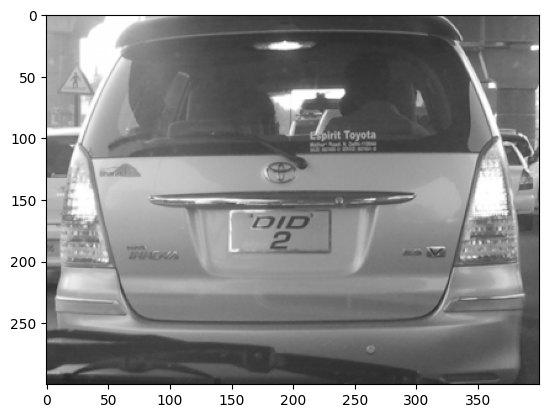

In [16]:

img = cv2.imread('archive/images/Cars213.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

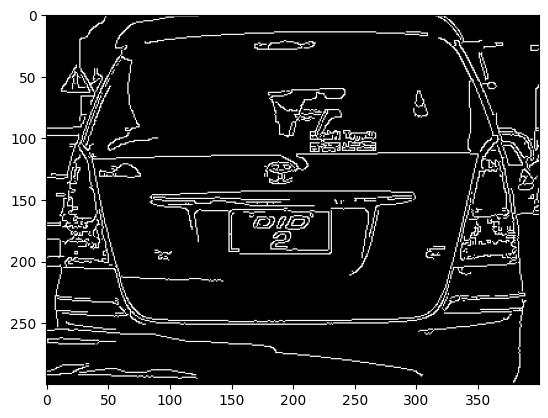

In [17]:
bfilter = cv2.bilateralFilter(gray, 11, 11, 17)
edged = cv2.Canny(bfilter, 30, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [18]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

location = None
for contour in contours:
  # cv2.approxPolyDP returns a resampled contour, so this will still return a set of (x, y) points
  approx = cv2.approxPolyDP(contour, 10, True)
  if len(approx) == 4:
    location = approx
    break

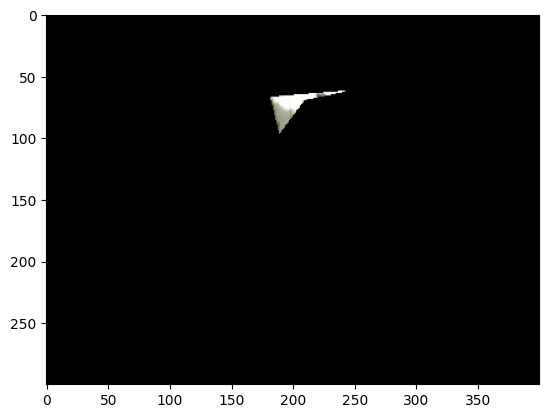

In [19]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask = mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

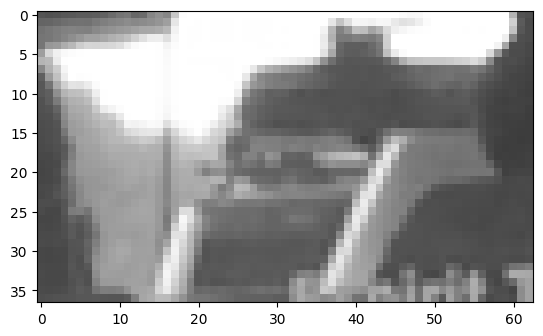

In [20]:
(x, y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
# Adding Buffer
cropped_image = gray[x1:x2+3, y1:y2+3]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [21]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
print(result)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[]


In [36]:
print(result[0][1])

IndexError: list index out of range

In [37]:
def load_and_resize_selected_images(image_directory, selected_filenames, resize_dims=(224, 224)):
    resized_images = []
    for filename in selected_filenames:
        full_path = os.path.join(image_directory, filename)
        if os.path.exists(full_path):
            img = cv2.imread(full_path)
            resized_img = cv2.resize(img, resize_dims)
            resized_images.append(resized_img)
        else:
            print(f"File {filename} not found in {image_directory}")

    return np.array(resized_images)

# Assuming 'selected_filenames' is the list of filenames you want to include
# selected_filenames = ['image1.png', 'image2.png', ...]  # Example filenames
images = load_and_resize_selected_images(image_directory, filenames)


In [38]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'labels' is the array of license plate codes
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


In [41]:
import tensorflow as tf

def create_model(num_classes, input_shape=(224, 224, 3)):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Assuming you have calculated 'num_classes' based on your encoded labels
num_classes = len(np.unique(encoded_labels))
model = create_model(num_classes=num_classes)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
3/3 [==============================] - 6s 1s/step - loss: 1068.2513 - accuracy: 0.0312 - val_loss: 1672.5884 - val_accuracy: 0.0000e+00
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 930.2248 - accuracy: 0.0625 - val_loss: 372.3380 - val_accuracy: 0.0000e+00
Epoch 3/10
3/3 [==============================] - 3s 1s/step - loss: 146.5787 - accuracy: 0.0938 - val_loss: 21.7776 - val_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 3s 1s/step - loss: 8.0238 - accuracy: 0.3333 - val_loss: 8.0019 - val_accuracy: 0.2500
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 1.4298 - accuracy: 0.7396 - val_loss: 4.8978 - val_accuracy: 0.4167
Epoch 6/10
3/3 [==============================] - 3s 1s/step - loss: 0.3873 - accuracy: 0.8854 - val_loss: 4.3966 - val_accuracy: 0.4583
Epoch 7/10
3/3 [==============================] - 4s 1s/step - loss: 0.1602 - accuracy: 0.9583 - val_loss: 4.0838 - val_accuracy: 0.4583
Epoch 8/10
3/3 [

In [43]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

1/1 [==============================] - 0s 389ms/step - loss: 2.1000 - accuracy: 0.8000
Test accuracy: 80.00%


1/1 [==============================] - 1s 687ms/step


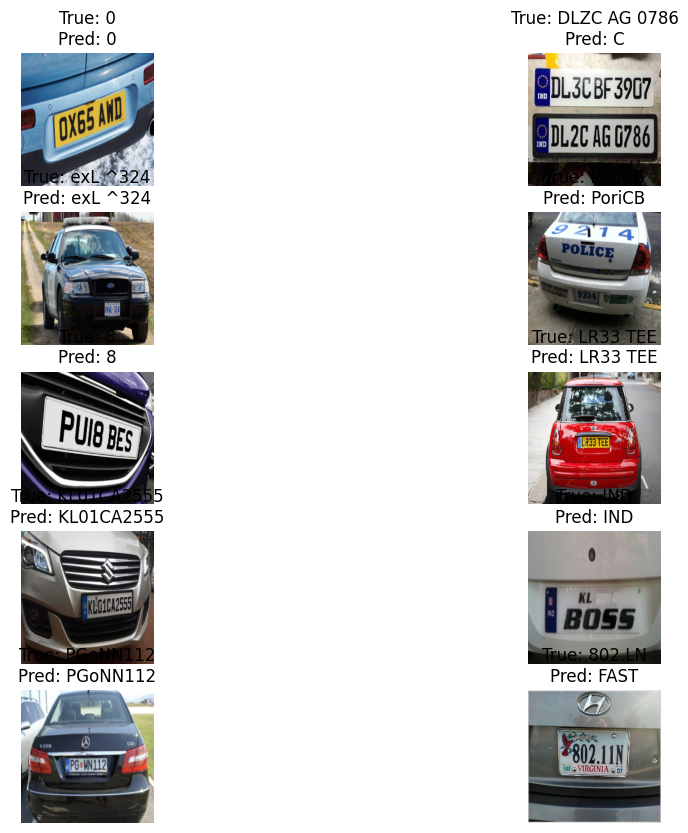

In [44]:
import matplotlib.pyplot as plt

def plot_predictions(images, true_labels, predictions, label_encoder, num_images=5):
    """
    Plot the images with their predicted labels and true labels.
    
    Parameters:
    images (numpy.array): Array of image data.
    true_labels (numpy.array): Array of actual labels (encoded).
    predictions (numpy.array): Array of predicted labels (encoded).
    label_encoder (LabelEncoder): Encoder object used to fit label data.
    num_images (int): Number of images to display.
    """
    plt.figure(figsize=(12, 10))
    
    for i in range(num_images):
        plt.subplot(num_images // 2, 2, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        
        # Decode the labels
        true_label = label_encoder.inverse_transform([true_labels[i]])[0]
        pred_label = label_encoder.inverse_transform([predictions[i]])[0]

        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')

# Predict the labels of the test images
predicted_labels = model.predict(X_test)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Plotting the results
plot_predictions(X_test, y_test, predicted_classes, label_encoder, num_images=10)


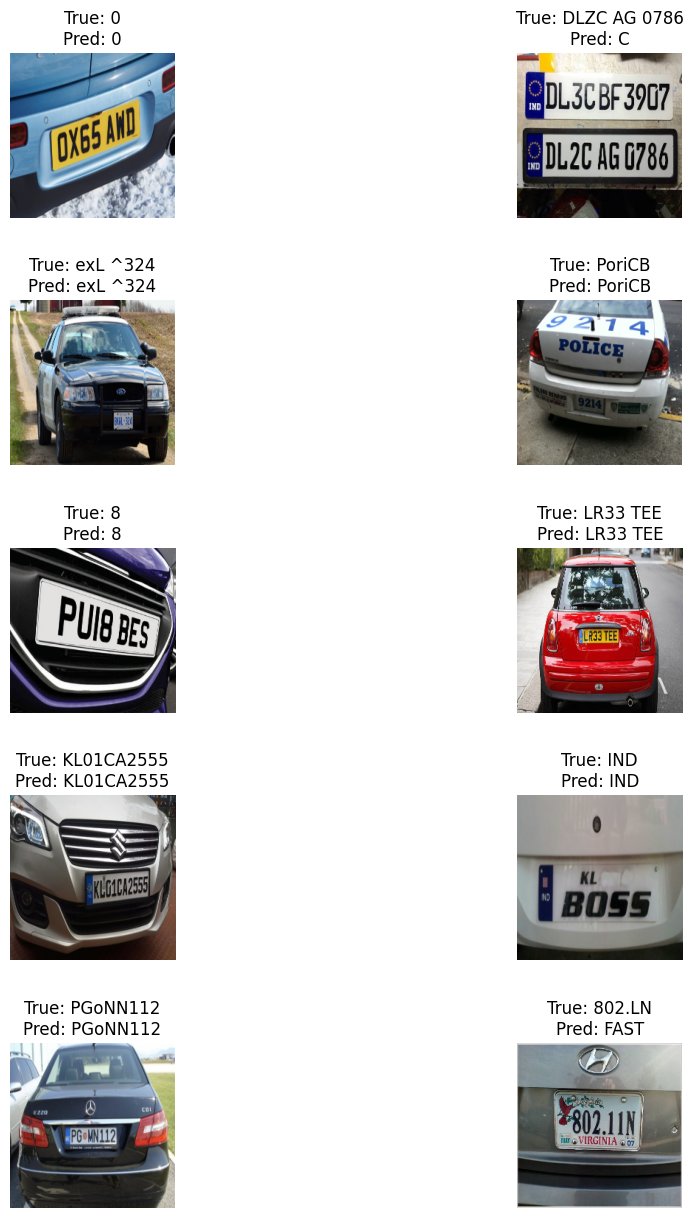

In [45]:
import matplotlib.pyplot as plt

def plot_predictions(images, true_labels, predictions, label_encoder, num_images=5):
    """
    Plot the images with their predicted labels and true labels.
    
    Parameters:
    images (numpy.array): Array of image data.
    true_labels (numpy.array): Array of actual labels (encoded).
    predictions (numpy.array): Array of predicted labels (encoded).
    label_encoder (LabelEncoder): Encoder object used to fit label data.
    num_images (int): Number of images to display.
    """
    num_cols = 2  # Number of columns in the subplot grid
    num_rows = (num_images + 1) // num_cols  # Compute the required number of rows

    plt.figure(figsize=(12, num_rows * 3))  # Dynamically adjust figure height based on the number of rows
    
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        
        # Decode the labels
        true_label = label_encoder.inverse_transform([true_labels[i]])[0]
        pred_label = label_encoder.inverse_transform([predictions[i]])[0]

        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.5)  # Adjust the horizontal space between panels

# Assuming you have predicted_classes, X_test, y_test, and label_encoder from your model's predictions
plot_predictions(X_test, y_test, predicted_classes, label_encoder, num_images=10)
